In [2]:
import pandas as pd
import numpy as np
import umap
import hdbscan

import warnings
warnings.filterwarnings("ignore")



pd.set_option('display.max_rows', 100)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 100)  # Auto-detect the display width
pd.set_option('display.max_colwidth', 100)  # Show full content of each cell


C:\Users\F1302\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("distinct_posts_with_text.csv", sep=",", encoding="utf-8")
df.head()

,post_importation_id,post_platform,post_id,post_type,pf_post_id,post_created_at,post_is_deduced,post_lang,post_url,account_id,pf_account_id,account_name,screen_name,description,account_lang,account_url,document_id,document_text,document_text_fr,document_text_en,document_lang,account_registered_at,account_profile_picture,account_followers,account_following,account_posts,account_views,engagements,reactions,comments,shares,views,quotes,citations,repartages
0,622,Twitter,5950190,post,155204550754697216,2012-01-06 08:30:23,False,fr,https://twitter.com/i/web/status/155204550754697216,2033581,99747172,philippe casquero,casqueroart,artiste peintre plasticien,NaN,https://twitter.com/casqueroart,8470122,"PERPIGNAN:Clotilde Ripoull,conseillère municipale d’opposition,dénonce « la pub du maire aux fra...","PERPIGNAN:Clotilde Ripoull,conseillère municipale d’opposition,dénonce « la pub du maire aux fra...",NaN,NaN,2009-12-27 17:31:27,https://pbs.twimg.com/profile_images/560304123216543744/efU2TsIK_normal.jpeg,308,881,1441,0,0,0,0,0,0,0,0,0
1,622,Twitter,5950191,post,158947882207154176,2012-01-16 16:25:02,False,fr,https://twitter.com/i/web/status/158947882207154176,2033582,271927894,CorpoDroit Perpignan,corpodroitperpi,Corpo Dret - Universitat Perpinyà Via Domitia,NaN,https://twitter.com/corpodroitperpi,8470124,"Cette année, la Corpo présentera une liste pour les élections aux conseil d'UFR SJE ! Celles-ci ...","Cette année, la Corpo présentera une liste pour les élections aux conseil d'UFR SJE ! Celles-ci ...",NaN,NaN,2011-03-25 13:21:19,https://pbs.twimg.com/profile_images/2153999367/Design_pin_s_final_normal.jpg,158,67,82,0,0,0,0,0,0,0,0,0
2,622,Twitter,5950192,post,162690472328966144,2012-01-27 00:16:45,False,fr,https://twitter.com/i/web/status/162690472328966144,2033583,213826152,ajouter rss,ajouterrss,Annuaire generaliste de Flux RSS libre. Soumettez gratuitement votre site Internet et Flux RSS s...,NaN,https://twitter.com/ajouterrss,8470126,Commissaire de quartiers de Perpignan: Presentation de l ordre informations sur la police munic...,Commissaire de quartiers de Perpignan: Presentation de l ordre informations sur la police munic...,NaN,NaN,2010-11-09 22:05:57,https://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png,47,0,75915,0,0,0,0,0,0,0,0,0
3,622,Twitter,5950193,post,163720388663185408,2012-01-29 20:29:17,False,fr,https://twitter.com/i/web/status/163720388663185408,2033584,321234473,Election France,election_fr,NaN,NaN,https://twitter.com/election_fr,8470128,"A Perpignan, Marine Le Pen rappelle le ""rêve du ‘Travailler plus …: | 29… #election","A Perpignan, Marine Le Pen rappelle le ""rêve du ‘Travailler plus …: | 29… #election",NaN,NaN,2011-06-21 07:17:09,https://pbs.twimg.com/profile_images/1405911001/image_normal.jpg,196,0,12399,0,0,0,0,0,0,0,0,0
4,622,Twitter,5950194,post,163720380329115648,2012-01-29 20:29:15,False,fr,https://twitter.com/i/web/status/163720380329115648,2033584,321234473,Election France,election_fr,NaN,NaN,https://twitter.com/election_fr,8470131,"A Perpignan, Marine Le Pen rappelle le ""rêve du ‘Travailler plus …: | 29.01… #2012","A Perpignan, Marine Le Pen rappelle le ""rêve du ‘Travailler plus …: | 29.01… #2012",NaN,NaN,2011-06-21 07:17:09,https://pbs.twimg.com/profile_images/1405911001/image_normal.jpg,196,0,12399,0,0,0,0,0,0,0,0,0


# Pipeline NLP - Spacy

In [4]:
%%time
import re
from tqdm import tqdm
import emoji
import spacy
import torch
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def load_spacy_model(model: str) -> spacy.language.Language:
    """
    Load a spaCy model with optional configurations.

    Args:
        model : str
            Name of the spaCy model to load.

    Returns:
        nlp : spacy.language.Language
            Loaded spaCy language processing pipeline.

    """
    if torch.cuda.is_available():
        spacy.prefer_gpu()

    nlp = spacy.load(model)

    return nlp

def clean_text(text: str) -> str:
    text = emoji.replace_emoji(text, replace="")
    text = re.sub(r"\s+", " ", text)  # Normalize whitespace
    text = text.strip()  # Remove leading/trailing spaces
    return text

def spacy_NER(nlp, df: pd.DataFrame, col_text: str, entities_to_keep: list = ['PERSON','ORG', 'LOC'], explode: bool = True, batch_size : int = 1000, n_process: int =8) -> pd.DataFrame:
    """
    Spacy implementation of NER.
    To define entities type to keep, call get_labels(nlp, pipe_step="ner", explanations=False)
    explode = False means it returns 1 list of entities per document
    explode = True means it returns 1 entity per row

    Args:
        nlp : spacy.language.Language
            The spaCy language processing pipeline.
        df : pd.DataFrame
            DataFrame containing the text data.
        col_text : str
            The name of the column containing the text data.
        entities_to_keep : list, optional
            List of entity types to keep. Default is ['PERSON','ORG', 'LOC'].
        batch_size : int, optional
            Batch sizes
        n_process : int, optional
            Number of processes

    Returns:
        pd.DataFrame
            DataFrame containing the NER information.

    Description:
        This function performs Named Entity Recognition (NER) using spaCy on a DataFrame with text data. It extracts entities of the specified types
        and stores the NER information in separate columns.
    """
    df[col_text] = df[col_text].apply(clean_text)
    l_text = df[col_text].tolist()
    all_records = []
    for doc in tqdm(nlp.pipe(l_text, batch_size=batch_size, n_process=n_process), total= len(l_text), desc = "NLP Process"):
        NER_type = []
        NER_text = []

        if len(entities_to_keep)>0:
            for ent in doc.ents:
                if ent.label_ in entities_to_keep:
                    NER_type.append(ent.label_)
                    NER_text.append(ent.text)
        else:
            for ent in doc.ents:
                NER_type.append(ent.label_)
                NER_text.append(ent.text)
        record = (NER_type, NER_text)
        all_records.append(record)

    df[['NER_type', 'NER_text']] = pd.DataFrame(all_records, index=df.index)

    return df


def generate_wordcloud(df: pd.DataFrame,
                       col_word: str,
                       col_metric: str,
                       width: int = 1500,
                       height: int = 750,
                       dpi: int = 72,
                       background_color: str = 'white',
                       show: bool = False) -> WordCloud:
    """
    Generate a word cloud from a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing word frequency data.
        col_word (str): Column name containing words.
        col_metric (str): Column name containing frequency metrics for each word.
        width (int, optional): Width of the word cloud image. Defaults to 3000.
        height (int, optional): Height of the word cloud image. Defaults to 1500.
        dpi (int, optional): Dots per inch for image resolution. Defaults to 300.
        background_color (str, optional): Background color of the word cloud image. Defaults to 'white'.
        show (bool, optional): Whether to display the word cloud image. Defaults to False.

    Returns:
        WordCloud: WordCloud object representing the generated word cloud.
    """

    top_n_words={row[col_word]:row[col_metric] for i,row in df.iterrows()}
    # top_n_words = dict(zip(df.col_word, df.col_metric)) ## plus optmisé

    # Generate a wordcloud of the top n words
    wordcloud = WordCloud(width=width, height=height, background_color=background_color, prefer_horizontal=1).generate_from_frequencies(top_n_words)
    if show :
        plt.figure(figsize=(width/dpi, height/dpi), dpi=dpi)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()
    return wordcloud



# on charge notre modèle
nlp = load_spacy_model("fr_core_news_lg")

# on affiche les labels disponibles pour le modèle chargé et la fonction linguistique visée
pipe_details = nlp.get_pipe("ner")
labels=list(pipe_details.labels)
print(labels)

['LOC', 'MISC', 'ORG', 'PER']
CPU times: total: 10.8 s
Wall time: 13.9 s


In [5]:
# %%time
# # Ici on sélectionne le type d'entités nommées à détecter
# entity_labels = ['LOC', 'ORG', 'PER']


# # on utilise la fonction de détection d'entitées nommées
# df = spacy_NER(nlp, df, "document_text_fr", entities_to_keep = [], batch_size = 512, n_process = 1)

# # on crée un nouveau dataframe où 1 ligne = 1 entitée
# df_entities = df.copy()
# df_entities = df_entities[df_entities['NER_type'].apply(lambda x: len(x) > 0)]
# df_entities = df_entities.explode(['NER_type', 'NER_text'])

# # on affiche les entitées les plus fréquemment citées
# for NER_type in labels:
#   df_top_entities = (
#                       df_entities[df_entities['NER_type']== NER_type].groupby(['NER_text', 'NER_type'])
#                       .agg({"post_id":'nunique'})
#                       .sort_values(by="post_id", ascending=False)
#                       .reset_index()
#                     )
#   print(NER_type)
#   generate_wordcloud(df_top_entities.head(50), "NER_text", "post_id", show = True)
#   print('\n'*3)

# Lemmatisation

In [6]:
from spacy.lang.fr.stop_words import STOP_WORDS as sw


In [7]:
# Lemmatisation
for i in sw:
  _ = nlp(i)
  for ent in _.ents:
    if ent.label_ in labels:
      print(i, ent.label_)

vôtre LOC
nôtres LOC
aupres LOC
hem PER
da LOC
tiennes LOC
ouste PER
houp PER
moindres LOC
apres LOC
hue PER
memes LOC
hep MISC
ouias PER
etais LOC
voila PER
malgre LOC
vas MISC
ça MISC
prealable PER
dejà MISC
vôtres LOC
mienne LOC
basee ORG
vé PER
anterieure LOC
elles-memes MISC
revoila LOC


In [8]:
df.document_text_fr[df.document_text_fr.apply(lambda x : ("\t") in x)].values

array([], dtype=object)

In [9]:
%%time 

def clean_text(text: str) -> str:
    text = emoji.replace_emoji(text, replace="")
    text = re.sub(r"\s+", " ", text)  # Normalize whitespace
    text = text.strip()
    text = text.lower()  # Remove leading/trailing spaces
    return text

def lemmatization(nlp, df: pd.DataFrame, col_text: str, col_lemma: str, pos_to_keep: list = [], stopwords: list = sw, batch_size: int = 512, n_process: int = 1, join_list: bool = False) -> pd.DataFrame:
    """
    Perform natural language processing tasks using spaCy : tokenization, PoS Tagging and lemmatization

    Args:
        nlp : spacy.Language
            The spaCy language model.
        df : pandas.DataFrame
            The DataFrame containing the text data.
        col_text : str
            The name of the column containing the text data.
        col_lemma : str
            The name of the column to store the lemmatized text data.
        pos_to_keep : list
            A list of part-of-speech tags to keep during lemmatization.
        stopwords : list
            A list of stopwords to remove during processing.
        batch_size : int, optional
            The batch size for spaCy processing. Default is 100.
        n_process : int, optional
            The number of processes for parallel processing. Default is 1.
        join_list : bool, optional
            Whether to join the lemmas into a single string. Default is False.

    Returns:
        pandas.DataFrame
            The DataFrame with processed text data.

    """

    df[col_text] = df[col_text].apply(clean_text)

    all_lemmas=[]
    
    text=list(df[col_text].astype('unicode').values)

    for doc in tqdm(nlp.pipe(text, batch_size=batch_size, n_process=n_process), total= len(text), desc = "NLP Process"):

# garde uniquement les mots pertinents, flitre
        if len(pos_to_keep)>0 and len(stopwords)>0:
            lemmas_list = [str(tok.lemma_).lower() for tok in doc if not (tok.is_punct or tok.is_space) and tok.text.lower() not in stopwords and tok.pos_ in pos_to_keep]
        elif len(pos_to_keep)>0 and len(stopwords) < 1:
            lemmas_list = [str(tok.lemma_).lower() for tok in doc if not (tok.is_punct or tok.is_space) and tok.pos_ in pos_to_keep]
        elif len(pos_to_keep) < 1 and len(stopwords) > 0:
            lemmas_list = [str(tok.lemma_) for tok in doc if not (tok.is_punct or tok.is_space) and tok.text.lower() not in stopwords ]
        else :
            lemmas_list = [str(tok.lemma_).lower() for tok in doc if not (tok.is_punct or tok.is_space)]

        all_lemmas.append(lemmas_list)

    if join_list:
        df[col_lemma]=[' '.join(map(str, l)) for l in all_lemmas]
    else:
        df[col_lemma]=all_lemmas

    return df

# toujours à l'aide de notre modèle spacy, on lemmatise le texte en ne conservant que certains PoS tags

df = lemmatization(nlp, df, "document_text_fr", "lemmatized_text", pos_to_keep=[], stopwords = list(sw), batch_size = 512, n_process = 1, join_list = True)
print(df["lemmatized_text"])

NLP Process: 100%|██████████| 12263/12263 [01:06<00:00, 184.62it/s]

0            perpignan clotilde ripoull conseiller municipal opposition dénoncer pub maire frais perpignanai
1                                              année corpo présenter liste élection conseil ufr sje dérouler
2                           commissaire quartier perpignan presentation l ordre information police municipal
3                                                perpignan marine pen rappeler rêve travailler | 29 election
4                                                 perpignan marine pen rappeler rêve travailler | 29.01 2012
                                                        ...                                                 
12258    marine pen risque peine inéligibilité exécution provisoire pouvoir présenter élection présidenti...
12259    19 juin débuter tribunal perpignan procès maire barcarè alain ferrand prise illégal intérêt cas ...
12260                                           procès rn louis aliot zone turbulence an municipal perpignan
12261    abstention

# Topic Modeling - Etape n°1 - Vectorisation

On va transformer nos textes en vecteurs ("embeddings") à l'aide d'un modèle pré-entrainé de type "SentenceTransformer".


In [10]:
# def load_HF_embeddings(model_name : str, encode_kwargs : dict ={'batch_size':32}, model_kwargs : dict ={'device': 'cuda:0'}):
#     """
#     create a HugginFace encoder
#     """
#     try:
#         HF_encoder = HuggingFaceEmbeddings(model_name=model_name, encode_kwargs = encode_kwargs, model_kwargs=model_kwargs)
#         return HF_encoder
#     except Exception as e:
#         pass
#         print(e)


# def HF_vectorize(HF_encoder, lst_txt):
#     """
#     Vectorize using a Huggingface encoder
#     """
#     embeddings = HF_encoder.embed_documents(lst_txt)

#     return embeddings

In [11]:
# # Fast and efficient model for French (multilingual-MiniLM)
from sentence_transformers import SentenceTransformer
model_fast_fr = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
# # Encode the French texts
embeddings_fast_fr = model_fast_fr.encode(list(df['document_text_fr']))
df['embeddings_fast_fr'] = (embeddings_fast_fr).tolist()


# sample_embeddings_fast_fr = model_fast_fr.encode(list(df_sample['document_text_fr']))    6 min et 14 sec
# not_sample_embeddings_fast_fr = model_fast_fr.encode(list(df_not_sample['document_text_fr']))
# print(f"Fast French model embeddings shape: {sample_embeddings_fast_fr.shape}")


In [12]:
# Higher quality French model
from sentence_transformers import SentenceTransformer
model_quality_fr = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")
# Encode the French texts
embeddings_quality_fr = model_quality_fr.encode(list(df['document_text_fr']))
df['embeddings_quality_fr'] = (embeddings_quality_fr).tolist()

# sample_embeddings_quality_fr = model_quality_fr.encode(list(df_sample['document_text_fr']))
# not_sample_embeddings_quality_fr = model_quality_fr.encode(list(df_not_sample['document_text_fr']))
# print(f"Quality French model embeddings shape: {sample_embeddings_quality_fr.shape}")

In [13]:
# Basic/slower model for French (less effective)
from sentence_transformers import SentenceTransformer
model_basic_fr = SentenceTransformer("distiluse-base-multilingual-cased-v1")
# Encode the French texts
embeddings_basic_fr = model_basic_fr.encode(list(df['document_text_fr']))
df['embeddings_basic_fr'] = (embeddings_basic_fr).tolist()

# sample_embeddings_basic_fr = model_basic_fr.encode(list(df_sample['document_text_fr']))
# not_sample_embeddings_basic_fr = model_basic_fr.encode(list(df_not_sample['document_text_fr']))
# print(f"Basic French model embeddings shape: {sample_embeddings_basic_fr.shape}")

In [ ]:
# Stocke les resultats precedents dans un fichier csv
# fait une condition d'utilisation du knn (sklearn ou umap)

# Sampling


In [14]:
df_sample = df[~df["document_text_fr"].duplicated()].sample(10000, random_state=42)
print(df_sample.shape)
df_not_sample =  df[~df['post_id'].isin(df_sample['post_id'])]
df_not_sample.shape


(10000, 39)


(2263, 39)

# Etape n°2 - Réduction de dimensions
Chaque texte est désormais représenté par un vecteur en 300, à 800 dimensions. On va effectuer une réduction de dimensions pour

*   facilement représenter le résultat en 2 ou 3 dimensions
*   limiter les calculs
* s'intéresser aux dimensions les plus "significatives"


## Fast model (Erwan)

Reduced embeddings shape: (10000, 2)


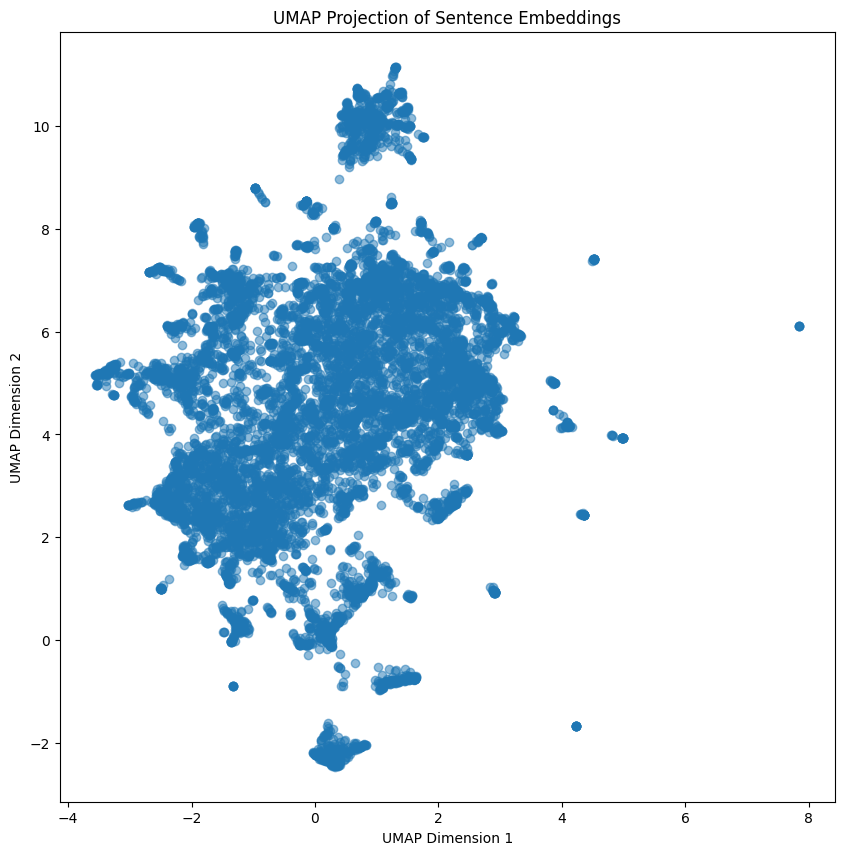

CPU times: total: 46.2 s
Wall time: 42.7 s


In [15]:
%%time
import umap
import matplotlib.pyplot as plt
import plotly.express as px
import nbformat  # !!!!!!!!!!!!!!!!!

parameters = {"n_neighbors": 15,
              "n_components": 2,
              "min_dist": 0.00,
              "metric": "cosine",
              "spread": 1,
              "random_state": 42,
              "n_epochs": 1000,
              "learning_rate": 1
             }

# Fit the UMAP model on your embeddings
sample_embeddings_fast_fr = np.array(df_sample['embeddings_fast_fr'].tolist())


reducer = umap.UMAP(**parameters).fit(sample_embeddings_fast_fr)

# Transform the embeddings to 2D
sample_reduced_embeddings = reducer.transform(sample_embeddings_fast_fr)

# Print the shape of the reduced embeddings
print(f"Reduced embeddings shape: {sample_reduced_embeddings.shape}")

# Add the coordinates to your dataframe
df_sample['x'] = sample_reduced_embeddings[:,0]
df_sample['y'] = sample_reduced_embeddings[:,1]


# Create a matplotlib figure
plt.figure(figsize=(10, 10))
plt.scatter(df_sample['x'], df_sample['y'], alpha=0.5)
plt.title('UMAP Projection of Sentence Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [16]:
# # Transform not_sample embeddings using the same reducer
# not_sample_reduced_embeddings = reducer.transform(not_sample_embeddings_fast_fr)

# # Add the coordinates to the not_sample dataframe
# df_not_sample['x'] = not_sample_reduced_embeddings[:,0]
# df_not_sample['y'] = not_sample_reduced_embeddings[:,1]

# # Add source column to distinguish between datasets
# df_sample['source'] = 'sample'
# df_not_sample['source'] = 'not_sample'

# # Concatenate the dataframes
# df_concat = pd.concat([df_sample, df_not_sample])

# # Create the plot using matplotlib
# plt.figure(figsize=(12, 12))

# # Plot sample points
# sample_data = df_concat[df_concat['source'] == 'sample']
# plt.scatter(sample_data['x'], sample_data['y'], color='blue', alpha=0.6, label='Sample')

# # Plot not_sample points
# not_sample_data = df_concat[df_concat['source'] == 'not_sample']
# plt.scatter(not_sample_data['x'], not_sample_data['y'], color='red', alpha=0.6, label='Not Sample')

# # Add labels and legend
# plt.title('UMAP Projection of Sentence Embeddings', fontsize=16)
# plt.xlabel('UMAP Dimension 1', fontsize=14)
# plt.ylabel('UMAP Dimension 2', fontsize=14)
# plt.legend(fontsize=12)
# plt.grid(alpha=0.3)

# # Show the plot
# plt.show()

# # Print some statistics
# print(f"Number of sample points: {len(sample_data)}")
# print(f"Number of not_sample points: {len(not_sample_data)}")


## Higher quality 

Reduced embeddings shape: (10000, 2)


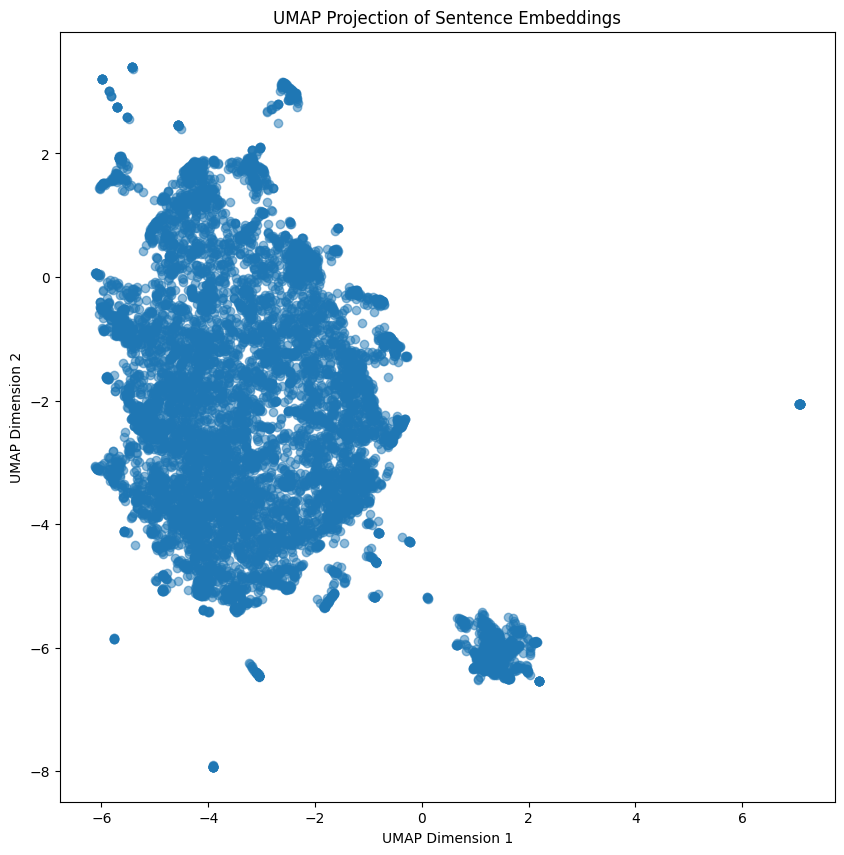

CPU times: total: 29.8 s
Wall time: 23.8 s


In [17]:
%%time
import umap
import matplotlib.pyplot as plt
import plotly.express as px
import nbformat  # !!!!!!!!!!!!!!!!!

parameters = {"n_neighbors": 20,
              "n_components": 2,
              "min_dist": 0.00,
              "metric": "cosine",
              "spread": 1,
              "random_state": 42,
              "n_epochs": 1000,
              "learning_rate": 0.51
             }

# Fit the UMAP model on the embeddings
sample_embeddings_quality_fr = np.array(df_sample['embeddings_quality_fr'].tolist())
reducer = umap.UMAP(**parameters).fit(sample_embeddings_quality_fr)

# Transform the embeddings to 2D
sample_reduced_embeddings = reducer.transform(sample_embeddings_quality_fr)

# Print the shape of the reduced embeddings
print(f"Reduced embeddings shape: {sample_reduced_embeddings.shape}")

# Add the coordinates to your dataframe
df_sample['x'] = sample_reduced_embeddings[:,0]
df_sample['y'] = sample_reduced_embeddings[:,1]


# Create a matplotlib figure
plt.figure(figsize=(10, 10))
plt.scatter(df_sample['x'], df_sample['y'], alpha=0.5)
plt.title('UMAP Projection of Sentence Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

Reduced embeddings shape: (10000, 2)


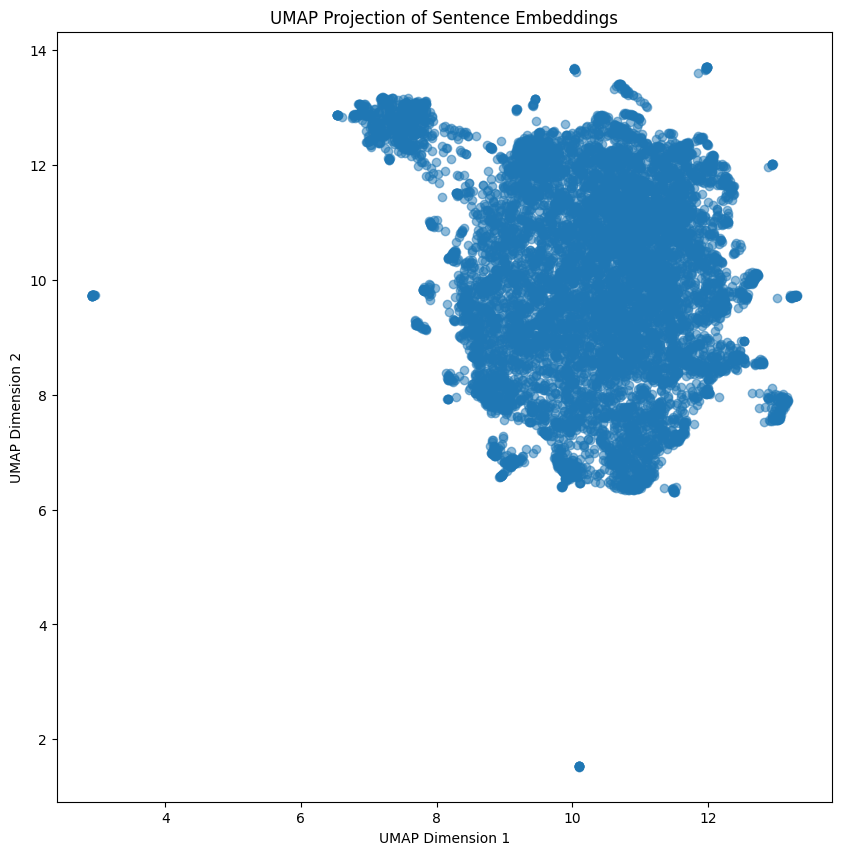

CPU times: total: 32.7 s
Wall time: 25.8 s


In [18]:
%%time
import umap
import matplotlib.pyplot as plt
import plotly.express as px
import nbformat  # !!!!!!!!!!!!!!!!!

parameters = {"n_neighbors": 25,
              "n_components": 2,
              "min_dist": 0.1,
              "metric": "cosine",
              "spread": 0.8,
              "random_state": 42,
              "n_epochs": 1000,
              "learning_rate": 0.01
             }

# Fit the UMAP model on your embeddings
reducer = umap.UMAP(**parameters).fit(sample_embeddings_quality_fr)

# Transform the embeddings to 2D
sample_reduced_embeddings = reducer.transform(sample_embeddings_quality_fr)

# Print the shape of the reduced embeddings
print(f"Reduced embeddings shape: {sample_reduced_embeddings.shape}")

# Add the coordinates to your dataframe
df_sample['x'] = sample_reduced_embeddings[:,0]
df_sample['y'] = sample_reduced_embeddings[:,1]


# Create a matplotlib figure
plt.figure(figsize=(10, 10))
plt.scatter(df_sample['x'], df_sample['y'], alpha=0.5)
plt.title('UMAP Projection of Sentence Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [19]:
# # Transform not_sample embeddings using the same reducer
# not_sample_reduced_embeddings = reducer.transform(not_sample_embeddings_quality_fr)

# # Add the coordinates to the not_sample dataframe
# df_not_sample['x'] = not_sample_reduced_embeddings[:,0]
# df_not_sample['y'] = not_sample_reduced_embeddings[:,1]

# # Add source column to distinguish between datasets
# df_sample['source'] = 'sample'
# df_not_sample['source'] = 'not_sample'

# # Concatenate the dataframes
# df_concat = pd.concat([df_sample, df_not_sample])

# # Create the plot using matplotlib
# plt.figure(figsize=(12, 12))

# # Plot sample points
# sample_data = df_concat[df_concat['source'] == 'sample']
# plt.scatter(sample_data['x'], sample_data['y'], color='blue', alpha=0.6, label='Sample')

# # Plot not_sample points
# not_sample_data = df_concat[df_concat['source'] == 'not_sample']
# plt.scatter(not_sample_data['x'], not_sample_data['y'], color='red', alpha=0.6, label='Not Sample')

# # Add labels and legend
# plt.title('UMAP Projection of Sentence Embeddings', fontsize=16)
# plt.xlabel('UMAP Dimension 1', fontsize=14)
# plt.ylabel('UMAP Dimension 2', fontsize=14)
# plt.legend(fontsize=12)
# plt.grid(alpha=0.3)

# # Show the plot
# plt.show()

# # Print some statistics
# print(f"Number of sample points: {len(sample_data)}")
# print(f"Number of not_sample points: {len(not_sample_data)}")


## Simple model

Reduced embeddings shape: (10000, 2)


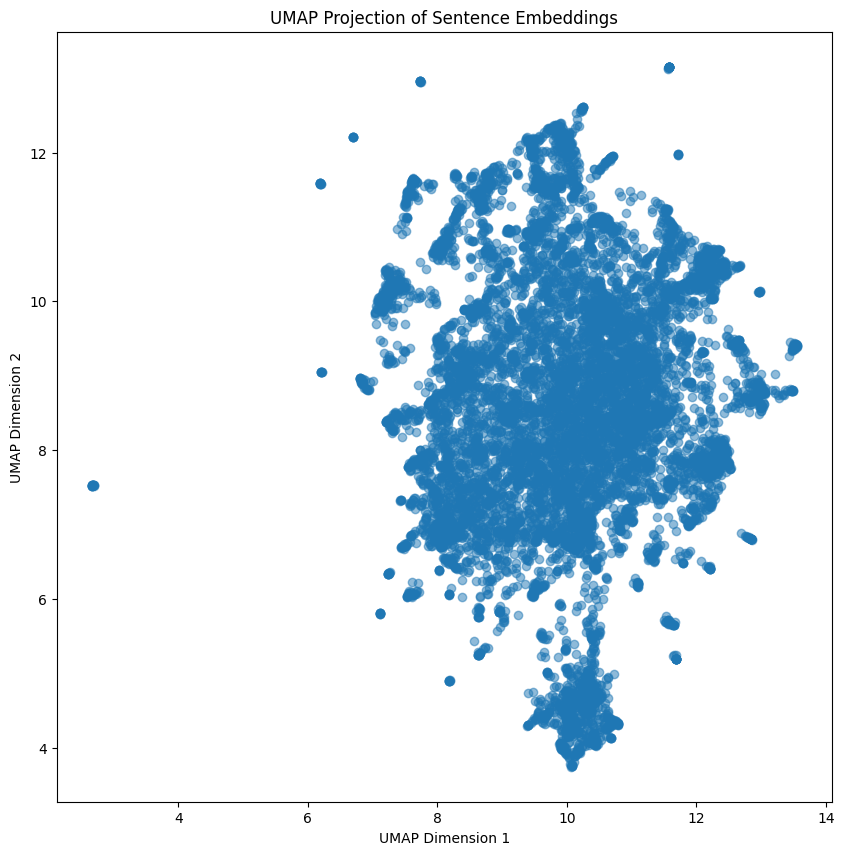

CPU times: total: 25.1 s
Wall time: 21.3 s


In [20]:
%%time
import umap
import matplotlib.pyplot as plt
import plotly.express as px
import nbformat  # !!!!!!!!!!!!!!!!!

parameters = {"n_neighbors": 15,
              "n_components": 2,
              "min_dist": 0.1,
              "metric": "cosine",
              "spread": 0.8,
              "random_state": 42,
              "n_epochs": 1000,
              "learning_rate": 0.01
             }

# Fit the UMAP model on your embeddings
sample_embeddings_basic_fr = np.array(df_sample['embeddings_basic_fr'].tolist())
reducer = umap.UMAP(**parameters).fit(sample_embeddings_basic_fr)

# Transform the embeddings to 2D
sample_reduced_embeddings = reducer.transform(sample_embeddings_basic_fr)

# Print the shape of the reduced embeddings
print(f"Reduced embeddings shape: {sample_reduced_embeddings.shape}")

# Add the coordinates to your dataframe
df_sample['x'] = sample_reduced_embeddings[:,0]
df_sample['y'] = sample_reduced_embeddings[:,1]


# Create a matplotlib figure
plt.figure(figsize=(10, 10))
plt.scatter(df_sample['x'], df_sample['y'], alpha=0.5)
plt.title('UMAP Projection of Sentence Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

In [21]:
# # Transform not_sample embeddings using the same reducer
# not_sample_reduced_embeddings = reducer.transform(not_sample_embeddings_basic_fr)

# # Add the coordinates to the not_sample dataframe
# df_not_sample['x'] = not_sample_reduced_embeddings[:,0]
# df_not_sample['y'] = not_sample_reduced_embeddings[:,1]

# # Add source column to distinguish between datasets
# df_sample['source'] = 'sample'
# df_not_sample['source'] = 'not_sample'

# # Concatenate the dataframes
# df_concat = pd.concat([df_sample, df_not_sample])

# # Create the plot using matplotlib
# plt.figure(figsize=(12, 12))

# # Plot sample points
# sample_data = df_concat[df_concat['source'] == 'sample']
# plt.scatter(sample_data['x'], sample_data['y'], color='blue', alpha=0.6, label='Sample')

# # Plot not_sample points
# not_sample_data = df_concat[df_concat['source'] == 'not_sample']
# plt.scatter(not_sample_data['x'], not_sample_data['y'], color='red', alpha=0.6, label='Not Sample')

# # Add labels and legend
# plt.title('UMAP Projection of Sentence Embeddings', fontsize=16)
# plt.xlabel('UMAP Dimension 1', fontsize=14)
# plt.ylabel('UMAP Dimension 2', fontsize=14)
# plt.legend(fontsize=12)
# plt.grid(alpha=0.3)

# # Show the plot
# plt.show()

# # Print some statistics
# print(f"Number of sample points: {len(sample_data)}")
# print(f"Number of not_sample points: {len(not_sample_data)}")


In [22]:
X = np.vstack(df_sample['embeddings_quality_fr'])


In [23]:
from sklearn.utils import check_random_state
random_state = check_random_state(0)

# Distance Metric to Use
metric = 'cosine'

# number of neighbors for computing k-neighbor graph
n_neighbors = 30

# new number of neighbors to search for
new_n_neighbors = 30

### Calculate a,b hyperparams given the min_dist

In [24]:
from umap.umap_ import find_ab_params

min_dist = 0
a, b = find_ab_params(1.0, min_dist)
print(a, b)

# ???

1.9328083983788007 0.7904949735308074


### Calculate the weighted nearest neighbor graph 

In [25]:
%%time
from umap.umap_ import nearest_neighbors

knn_indices, knn_dists, knn_search_index = nearest_neighbors(
    X,
    n_neighbors=n_neighbors,
    metric = metric,
    metric_kwds = {},
    angular=False,
    random_state = random_state,
    low_memory=True,
    use_pynndescent=True,
    n_jobs=1,
    verbose=True,
)



Mon May 19 01:06:45 2025 Finding Nearest Neighbors
Mon May 19 01:06:45 2025 Building RP forest with 10 trees
Mon May 19 01:06:45 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Mon May 19 01:06:49 2025 Finished Nearest Neighbor Search
CPU times: total: 4.16 s
Wall time: 4.2 s


In [26]:
knn_indices.shape, knn_dists.shape

((10000, 30), (10000, 30))

### Test de rapidité de knn de sklearn et knn de umap 

In [27]:
from umap.umap_ import nearest_neighbors
from sklearn.utils import check_random_state
import numpy as np
import time

# Simulation des données massives
X_big_umap = np.random.rand(100000, 1000).astype(np.float32)
n_neighbors_umap = 30
metric_umap = "cosine"
random_state_umap = check_random_state(42)

# Lancement du chrono
start_umap = time.time()

# Recherche des voisins avec UMAP + tous les arguments obligatoires
indices_umap, distances_umap, _ = nearest_neighbors(
    X_big_umap,
    n_neighbors=n_neighbors_umap,
    metric=metric_umap,
    metric_kwds={},         # requis mais vide ici
    angular=False,          # requis : False pour cosine, sauf si angular metric (approximation)
    random_state=random_state_umap,
    low_memory=True,
    use_pynndescent=True,
    n_jobs=-1,
    verbose=True,
)

end_umap = time.time()
print(f"[UMAP NNDescent] Temps total : {end_umap - start_umap:.2f} s")
print("Shape des résultats UMAP :", indices_umap.shape, distances_umap.shape)


Mon May 19 01:06:50 2025 Finding Nearest Neighbors
Mon May 19 01:06:50 2025 Building RP forest with 21 trees
Mon May 19 01:06:55 2025 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	 7  /  17
	 8  /  17
	 9  /  17
	 10  /  17
	 11  /  17
	Stopping threshold met -- exiting after 11 iterations
Mon May 19 01:07:17 2025 Finished Nearest Neighbor Search
[UMAP NNDescent] Temps total : 27.29 s
Shape des résultats UMAP : (100000, 30) (100000, 30)


In [64]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import time

# Simulation des mêmes données
X_big_sklearn = np.random.rand(30000, 100).astype(np.float32)
n_neighbors_sklearn = 30
metric_sklearn = "cosine"

# Initialisation du modèle exact
sklearn_knn_model = NearestNeighbors(
    n_neighbors=n_neighbors_sklearn,
    metric=metric_sklearn,
    algorithm='brute',  # Obligatoire pour 'cosine' ici
    n_jobs=-1
)

# Lancement du chrono
start_sklearn = time.time()

# Fit et recherche
sklearn_knn_model.fit(X_big_sklearn)
distances_sklearn, indices_sklearn = sklearn_knn_model.kneighbors(X_big_sklearn)

end_sklearn = time.time()
print(f"[Sklearn KNN] Temps total : {end_sklearn - start_sklearn:.2f} s")
print("Shape des résultats Sklearn :", indices_sklearn.shape, distances_sklearn.shape)


[Sklearn KNN] Temps total : 16.18 s
Shape des résultats Sklearn : (30000, 30) (30000, 30)


In [59]:
60000*400

24000000

In [42]:
10000*768

7680000

In [29]:
# Choix d'un point à comparer
i = 0  # ou un autre indice si tu veux tester plusieurs

# Récupérer les voisins
neighbors_umap = set(indices_umap[i])
neighbors_sklearn = set(indices_sklearn[i])

# Intersection
common_neighbors = neighbors_umap & neighbors_sklearn
n_common = len(common_neighbors)
recall = n_common / len(neighbors_sklearn)

# Affichage
print(f"Point {i}")
print(f"  - UMAP neighbors    : {sorted(list(neighbors_umap))[:10]} ...")
print(f"  - Sklearn neighbors : {sorted(list(neighbors_sklearn))[:10]} ...")
print(f"  - Commun : {n_common} / {len(neighbors_sklearn)} → Recall = {recall:.2%}")


Point 0
  - UMAP neighbors    : [np.int32(0), np.int32(224), np.int32(2409), np.int32(3670), np.int32(4885), np.int32(6039), np.int32(7698), np.int32(9187), np.int32(19448), np.int32(21083)] ...
  - Sklearn neighbors : [np.int64(0), np.int64(1088), np.int64(4183), np.int64(5513), np.int64(6224), np.int64(8139), np.int64(12431), np.int64(15860), np.int64(16827), np.int64(21389)] ...
  - Commun : 1 / 30 → Recall = 3.33%


In [30]:
recalls = []

for i in range(100):
    neighbors_umap = set(indices_umap[i])
    neighbors_sklearn = set(indices_sklearn[i])
    n_common = len(neighbors_umap & neighbors_sklearn)
    recalls.append(n_common / len(neighbors_sklearn))

print(f"Recall moyen sur 100 points : {np.mean(recalls):.2%}")


Recall moyen sur 100 points : 3.40%


In [33]:
#Explication du probleme de recouvrement 
from scipy.spatial.distance import pdist

dists = pdist(X[:1000], metric="cosine")
print(f"min: {dists.min():.4f}, max: {dists.max():.4f}, mean: {dists.mean():.4f}, std: {dists.std():.6f}")


min: 0.0023, max: 1.0339, mean: 0.4961, std: 0.129237


In [32]:
pd.DataFrame(X).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1000

In [22]:
import numpy as np
import umap
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import shortest_path
from networkx.convert_matrix import to_scipy_sparse_array



In [23]:
def fit_umap_mutual_knn(X, n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', 
                        mst_method='mst-min', path_neighbors=True, k_final=15, random_state=42):
    """
    Applique UMAP avec graphe mutual k-NN + MST-min + path neighbors (optionnel)
    """
    n_samples = X.shape[0]

    # Étape 1 : Graphe k-NN initial
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, n_jobs=-1)
    nn.fit(X)
    distances, indices = nn.kneighbors(X)

    # Graphe mutual k-NN (non orienté)
    adjacency = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in indices[i]:
            if i in indices[j]:
                # calcul distance
                if metric == 'cosine':
                    dot = np.dot(X[i], X[j]) / (np.linalg.norm(X[i]) * np.linalg.norm(X[j]) + 1e-10)
                    d = 1 - dot
                else:
                    d = np.linalg.norm(X[i] - X[j])
                adjacency[i, j] = d
                adjacency[j, i] = d

    # Graphe initial basé sur mutual k-NN
    G_mutual = nx.from_numpy_array(adjacency)

    # Étape 2 : Ajout de connectivité (MST)
    if mst_method == 'mst-min':
        print(" → Construction de la matrice de distances complète avec pdist...")
        full_dist_matrix = squareform(pdist(X, metric=metric))

        print(" → Construction du graphe MST...")
        G_dist = nx.from_numpy_array(full_dist_matrix)
        mst = nx.minimum_spanning_tree(G_dist)

        print(" → Ajout des arêtes MST manquantes...")
        for (u, v, d) in mst.edges(data=True):
            if not G_mutual.has_edge(u, v):
                G_mutual.add_edge(u, v, weight=d["weight"])
            else:
                G_mutual[u][v]['weight'] = d["weight"]
                # Nettoyer les poids pour éviter les cycles négatifs
        for u, v, d in G_mutual.edges(data=True):
            if d['weight'] < 0:
                d['weight'] = 0.0



    elif mst_method == 'none':
        print(" → Pas d’ajout de connexité supplémentaire. Graphe mutual k-NN seul utilisé.")

    # Étape 3 : Path Neighbors ou UMAP direct
    if path_neighbors:
        print(" → Calcul des distances de graphe (plus courts chemins)...")
        sp_dist = shortest_path(
            csgraph=to_scipy_sparse_array(G_mutual, weight='weight'),
            directed=False
        )

        print(" → Extraction des k plus proches voisins par chemin (path-based)...")
        indices_final = np.argsort(sp_dist, axis=1)[:, 1:k_final+1]  # on saute l'élément 0 (distance à soi-même)

        # Reconstruction du graphe pondéré final basé sur la distance de chemin
        graph_reconstructed = np.zeros((n_samples, n_samples), dtype=np.float32)
        for i in range(n_samples):
            for j in indices_final[i]:
                graph_reconstructed[i, j] = sp_dist[i, j]
        
        # Rendre le graphe symétrique
        graph_reconstructed = np.maximum(graph_reconstructed, graph_reconstructed.T)

        # UMAP sur distance pré-calculée
        reducer = umap.UMAP(
            n_neighbors=k_final,
            n_components=n_components,
            min_dist=min_dist,
            metric='precomputed',
            random_state=random_state
        )
        return reducer.fit_transform(graph_reconstructed)
    else:
        print(" → Application directe d’UMAP sur les vecteurs originaux...")
        reducer = umap.UMAP(
            n_neighbors=k_final,
            n_components=n_components,
            min_dist=min_dist,
            metric=metric,
            random_state=random_state
        )
        return reducer.fit_transform(X)


In [24]:
1+1

2

In [25]:
embedding_umap = fit_umap_mutual_knn(
    X=sample_embeddings_quality_fr[1500],
    n_neighbors=15,
    n_components=2,
    mst_method='mst-min',
    path_neighbors=True,
    k_final=15
)


ValueError: Expected 2D array, got 1D array instead:
array=[-8.40615034e-02  3.80003184e-01 -1.17452508e-02  1.30039915e-01
 -3.04073025e-03 -1.47984773e-01 -2.42356863e-02 -2.94528641e-02
  1.00057177e-01  1.00623839e-01  1.49468526e-01  3.71300690e-02
 -1.30030379e-01 -1.15044434e-02  9.76292118e-02 -1.81391984e-01
  6.12316467e-02  3.18856090e-02 -6.31698444e-02  1.97420120e-02
  6.69978112e-02 -2.34390497e-02  1.00793652e-01  8.24764445e-02
 -3.08616161e-02  4.72085141e-02 -8.00064653e-02  4.54659760e-02
  6.87495545e-02  4.55505811e-02 -8.22979882e-02  7.60848401e-03
  1.30446643e-01  1.46479949e-01  5.32494895e-02  8.10566768e-02
 -7.15830224e-03 -9.36935656e-03  1.16073325e-01 -1.93692043e-01
  7.26919770e-02  1.17750780e-03 -6.92639053e-02  5.40398760e-03
 -9.08612534e-02  6.36233017e-02 -7.53879175e-02 -3.22039910e-02
 -1.27074704e-01  5.84946759e-02  2.26611607e-02  1.59074306e-01
 -5.22670988e-03 -7.78633356e-02  4.22748923e-02 -9.57173035e-02
 -1.34607544e-02 -2.28608981e-01 -1.12855636e-01  5.56740351e-02
 -2.24024039e-02 -2.26357346e-03  9.99837294e-02  1.37556596e-02
 -5.78438584e-03  4.31953892e-02  1.72886372e-01  8.29053074e-02
 -4.60342243e-02 -9.62424129e-02  1.08354926e-01 -1.89832952e-02
  4.41386662e-02  1.02038912e-01 -2.85595451e-02  6.84941784e-02
  2.59313243e-03 -1.39655858e-01  3.43354978e-02  6.43223301e-02
  8.93904418e-02 -2.82375570e-02  1.23689268e-02  4.84709069e-02
 -1.17632695e-01  1.19979009e-01 -2.09067557e-02 -2.63037886e-02
 -8.01447630e-02 -8.66844598e-03  5.48314210e-03 -1.85069721e-02
  4.34192717e-02  7.94005543e-02  4.97267731e-02 -7.56683275e-02
  2.17414647e-02  1.42845050e-01  5.57582565e-02  1.54522181e-01
 -6.83870316e-02 -5.66058420e-02  1.42911067e-02  8.98404643e-02
  1.72806114e-01 -5.33270650e-02 -9.53593776e-02 -1.50576591e-01
 -3.97969270e-03  1.97529048e-03  1.06913306e-01  9.80027094e-02
 -6.65055364e-02 -2.16865703e-01 -1.04179107e-01 -4.56579849e-02
  2.12861579e-02 -6.52588578e-03  3.55911367e-02 -7.75169283e-02
  2.15160519e-01  3.56429699e-03 -8.57283920e-02 -3.36696915e-02
 -1.32850736e-01  3.95429730e-02 -1.47684067e-01  8.89015105e-03
  6.04065927e-03  1.87378302e-01 -1.38462424e-01 -1.38730481e-01
  1.12247095e-03  1.26173109e-01  8.11970048e-03 -9.43815894e-03
 -1.89239047e-02 -6.16922565e-02  2.93120239e-02 -8.43154564e-02
  1.15375668e-02 -2.29802039e-02 -3.57911885e-02 -8.79818425e-02
 -4.29481938e-02 -8.62766132e-02 -6.33399840e-03 -7.89813325e-02
 -3.74348164e-02  2.47584097e-02  1.50375262e-01  4.58970182e-02
 -3.29271220e-02 -1.06515056e-02 -6.82052970e-02 -4.66790572e-02
  8.77865031e-03 -7.48894960e-02 -4.60494943e-02 -4.57806252e-02
 -9.84874964e-02  4.03136574e-02 -1.81481570e-01  8.17495957e-02
  4.19858731e-02  5.49797937e-02 -3.12094595e-02 -1.06214702e-01
  2.23135188e-01 -7.57895559e-02 -1.23162784e-01  2.04102486e-01
  2.61894967e-02 -4.01246212e-02 -5.79154268e-02 -1.77085504e-01
 -1.12320051e-01 -2.62375146e-01  7.70251686e-03  9.99127626e-02
 -7.42911324e-02 -1.44756451e-01  4.96758744e-02  3.07677742e-02
  7.33511224e-02  1.84150171e-02 -2.54658125e-02 -1.71104968e-02
 -8.34534392e-02  3.89624154e-03  9.45017114e-02 -2.39388156e-03
  1.10327408e-01 -3.40834521e-02  7.97898248e-02 -3.87300849e-02
 -7.88452625e-02 -9.34012085e-02  5.95442280e-02  1.13554135e-01
 -2.35957708e-02 -8.10779110e-02  6.27098233e-02  3.18212546e-02
 -5.07735685e-02  7.91788101e-02  7.51088038e-02 -9.16179195e-02
  1.59544982e-02 -3.02855711e-04  2.19540685e-01  4.45259213e-02
 -7.62268202e-03 -2.13386677e-02  7.72207826e-02  9.17823389e-02
  5.20166457e-02  4.38987724e-02 -1.37618911e-02  1.20671615e-01
 -1.21803127e-01  7.68968388e-02 -2.21633576e-02 -1.03749909e-01
  1.11270137e-01  9.39859673e-02 -9.77357998e-02  7.38594010e-02
 -1.23160601e-01  2.34025549e-02 -8.07891339e-02 -4.69359346e-02
  1.78759649e-01 -5.00418544e-02  1.34058341e-01  1.12357130e-02
  2.02756375e-01 -1.09135553e-01  1.15335308e-01 -5.81820272e-02
 -3.22439782e-02 -8.86268988e-02 -2.03033481e-02 -4.31801416e-02
  1.23321369e-01 -2.94459723e-02  1.02268860e-01  9.39196721e-02
  1.26287401e-01  1.84849799e-02 -3.47160734e-02  1.07606232e-01
  1.69312954e-02 -1.24713264e-01  8.27324763e-02  9.17084664e-02
 -1.48503780e-02  7.83397630e-02  2.08384022e-01 -7.91764632e-02
 -1.23271151e-02  2.18960475e-02 -1.43285899e-03 -7.42129097e-03
  2.00568527e-01  4.24581356e-02  8.45654830e-02 -2.01764598e-01
  5.59122860e-03 -9.66870710e-02  3.18141282e-02  6.95483759e-02
 -1.62272807e-02 -7.87097868e-03  2.30253767e-02  8.00664164e-03
  6.16229023e-04  4.12436314e-02 -1.72806740e-01  8.09100121e-02
  7.98839480e-02 -2.51655877e-01  6.84822649e-02  2.10760273e-02
  1.02693820e-02  6.40046895e-02 -2.08802684e-03 -3.86223271e-02
  1.40879959e-01 -8.47882852e-02 -1.25630483e-01  1.30251378e-01
  2.45238934e-02 -1.32750466e-01  5.72769046e-02  6.99549168e-02
 -1.41539082e-01 -1.34457335e-01 -7.56079108e-02 -7.68212881e-03
  4.99969460e-02 -1.52708977e-01 -9.51791480e-02  4.12606597e-02
 -1.00105934e-01 -1.05645485e-01 -5.59168076e-03 -8.31187814e-02
 -2.20655631e-02 -7.33656213e-02 -4.39190082e-02  7.17306510e-02
  5.26363254e-02  3.50400433e-02  8.77153650e-02 -1.18451938e-01
  8.37149471e-02  2.25365907e-01  7.80119896e-02  5.37033677e-02
 -4.66719568e-02  4.49965242e-03 -7.51642734e-02  6.19087815e-02
  1.29072955e-02  8.12090486e-02 -1.16175838e-01  1.08977687e-02
 -3.22580412e-02  1.82750374e-01  4.56747077e-02 -4.40083146e-02
  8.29778090e-02 -1.35450521e-02 -9.96691138e-02 -1.86033621e-01
  4.70805168e-02  8.42823274e-03 -6.59476370e-02 -3.15541811e-02
  3.34254317e-02 -1.76369533e-01  5.17743491e-02  1.32262930e-01
 -4.27935332e-01  1.93769131e-02 -5.94001599e-02  3.24676000e-02
 -3.75617743e-02 -5.26959114e-02 -1.75303474e-01 -7.21759647e-02
 -2.95077227e-02 -6.93360716e-02 -5.24072461e-02 -3.48114893e-02
 -8.51701014e-03  8.72785375e-02 -9.43543538e-02  8.16562548e-02
 -1.40321285e-01 -2.90898699e-02 -7.98490122e-02  2.73920391e-02
 -7.91438445e-02  9.77478456e-03  3.72648314e-02  7.47048333e-02
 -3.45667191e-02  1.57535270e-01  6.44342303e-02 -9.28094145e-03
 -5.09649701e-02 -2.03722436e-02  6.52271956e-02  8.63119289e-02
  7.96255693e-02  9.67893470e-03  1.38683304e-01  3.35145891e-02
  4.66696955e-02  6.70062527e-02  1.37951702e-01 -1.63335633e-02
 -8.26184303e-02 -4.28365543e-02  4.98707872e-03  2.12323349e-02
  1.73939541e-01  3.54214340e-01  8.88392851e-02 -4.93345223e-02
 -1.93513073e-02 -1.63220279e-02 -1.37975644e-02  4.82588336e-02
 -1.12891719e-01 -4.17317152e-02  5.38551994e-02 -6.42095655e-02
 -1.47468895e-02  1.62286144e-02 -3.58418860e-02 -4.59764339e-02
  1.44993201e-01 -1.68009605e-02  4.79166843e-02  6.05725572e-02
 -9.89980027e-02 -1.73731446e-01 -1.06194817e-01 -1.97928064e-02
  1.90621898e-01 -2.51387563e-02 -5.67632504e-02 -6.74333498e-02
 -2.47183740e-02 -7.89118186e-02  2.76312567e-02 -1.15509452e-02
 -1.34941190e-01  8.95723104e-02  8.35378170e-02 -5.62200248e-02
  1.38154715e-01 -1.08744860e-01  7.79565722e-02  7.53868446e-02
 -4.06384543e-02  2.45202072e-02 -3.73311155e-03 -2.26988997e-02
 -7.09208399e-02  4.29612212e-02 -2.37330988e-01  9.35677662e-02
 -9.69420001e-02 -1.70951746e-02 -8.67807716e-02  7.35133737e-02
  6.55389950e-02  1.06478572e-01  9.09291878e-02 -9.22817178e-03
  5.30696698e-02  1.90704435e-01 -5.17480895e-02 -5.78711703e-02
  8.54876300e-04  4.96560708e-02 -8.97853523e-02  1.26848286e-02
 -1.31180599e-01  1.50365159e-01  2.64993869e-02 -6.26448542e-02
  4.95192520e-02 -2.34255046e-01  4.36184835e-03 -6.97099417e-02
 -4.65413257e-02  4.57354754e-01  1.32026389e-01  5.34369014e-02
 -6.40019923e-02 -1.93050504e-02 -1.28449481e-02  5.58431074e-02
 -1.58703290e-02  4.69475128e-02  1.27194717e-03 -3.75280678e-02
  8.47000256e-02  3.77925741e-03  7.39794746e-02 -4.21586558e-02
  4.53110449e-02 -1.78505108e-01  1.13519408e-01  5.41936345e-02
 -7.61695281e-02  2.02036113e-01 -1.33435866e-02 -3.21701616e-02
  4.04307544e-02  1.05004208e-02  1.87695369e-01  4.00786512e-02
  1.01751141e-01  1.39065668e-01  3.93663570e-02  1.00455724e-01
 -9.37414169e-02 -8.56340379e-02 -1.46238044e-01 -5.08864336e-02
 -1.11969627e-01 -1.06225766e-01 -1.08626902e-01 -1.00519620e-01
 -4.29641902e-02  3.08501255e-02  9.06115100e-02  2.59226095e-02
  4.60784845e-02 -5.22660315e-02  6.09815121e-02 -5.76778054e-02
 -1.14861066e-02  2.20276117e-02  4.98155579e-02  7.04408064e-02
 -1.62608370e-01  1.33051857e-01 -1.05163986e-02  1.43952325e-01
  1.80019811e-01  1.03244081e-01  3.35761048e-02 -3.89967300e-02
 -1.81209240e-02 -2.37699170e-02 -5.07341102e-02 -2.17853431e-02
 -3.63110043e-02 -6.81717843e-02 -3.50344852e-02 -4.89682145e-02
 -6.17370345e-02  2.34006476e-02 -2.18374565e-01 -1.14746809e-01
  8.44616294e-02  3.21225002e-02 -6.06424510e-02 -1.39942154e-01
 -2.49717999e-02  3.01856156e-02  8.70251737e-04 -6.93037063e-02
  1.04695305e-01 -5.42242597e-05  1.65954962e-01  6.44323304e-02
 -1.04910746e-01 -1.98037717e-02 -3.20857503e-02  3.04439082e-03
 -3.24461199e-02  1.41295239e-01 -8.18030257e-03  4.03981023e-02
 -1.01103701e-01 -7.98092708e-02  2.28366517e-02 -7.52756968e-02
 -5.04035167e-02 -7.12196976e-02  2.76177051e-03 -1.05868708e-02
 -1.23709571e-02 -7.51183257e-02  7.25051016e-02  1.16475075e-02
 -1.00251161e-01  9.03404411e-03 -6.51205108e-02 -4.39575985e-02
  3.60858962e-02  1.34418219e-01  8.32057074e-02 -4.61854041e-02
  1.55102700e-01  6.23079538e-02 -5.17833494e-02  6.85075969e-02
 -2.16138344e-02  3.83055545e-02 -3.14708389e-02 -1.83459014e-01
 -2.18105569e-01 -5.66342510e-02  4.52086888e-02  9.95770171e-02
  7.56916031e-02  9.84796230e-03  6.15375899e-02  9.73615870e-02
  1.70664657e-02  5.78509234e-02 -3.83958481e-02  1.76203195e-02
  1.31717563e-01 -8.51277485e-02 -5.47508672e-02  8.18608142e-03
  7.65460134e-02 -3.35365869e-02  3.08581628e-02  2.21194904e-02
  1.67062283e-02  8.21549520e-02 -9.70745552e-03  5.46952561e-02
 -1.25092104e-01 -3.49918194e-02  4.86345254e-02  3.12863961e-02
  8.55408330e-03 -1.31095992e-02  7.81386998e-03  1.79506898e-01
  7.23915026e-02  3.60105336e-02 -1.01907454e-01  2.20497046e-02
 -1.77971479e-02  9.54676345e-02  7.50883296e-02 -9.67756957e-02
  1.28291041e-01  9.43102222e-03  4.45129015e-02 -1.35583626e-02
  7.38612786e-02 -3.42691364e-03  1.74964778e-03 -3.04146530e-03
  2.23984085e-02  3.93411930e-04  1.03679024e-01  1.60681754e-02
 -1.21578000e-01 -2.20882706e-02  2.54963171e-02  9.00151059e-02
 -1.97435077e-02 -6.39295131e-02 -3.86280008e-02  4.95138429e-02
 -5.35449982e-02 -1.47052128e-02  2.21659560e-04  2.34371293e-02
  4.96422537e-02 -1.88857224e-02  6.10687211e-02 -8.29068869e-02
  1.16331659e-01 -4.64338139e-02 -5.86710572e-02  3.74430381e-02
 -1.73348784e-01 -2.90762577e-02  3.83784771e-02  2.15005130e-01
 -4.38799597e-02 -5.55763543e-02 -4.78830747e-02 -3.91327813e-02
 -8.10466334e-02  7.91648477e-02 -3.59560386e-03 -5.45436889e-03
 -1.28124595e-01 -2.21335851e-02 -3.50200124e-02  2.68561933e-02
 -2.38735764e-03  4.82278951e-02  4.10704985e-02 -8.52528661e-02
 -2.34551132e-02  3.03323362e-02 -1.54641666e-03  9.89484116e-02
  8.68765935e-02  5.28061390e-02 -4.65117991e-02  1.36285096e-01
 -1.17730655e-01  1.35827616e-01 -1.87949426e-02  1.02649227e-01
  6.83448315e-02 -4.65543047e-02  1.71673596e-02 -2.29652342e-03
  2.48883795e-02  1.40805077e-02 -5.34910150e-02 -1.30450755e-01
  1.83597967e-01 -6.03857115e-02 -5.75070940e-02  2.80758049e-02
  7.87015781e-02 -4.22461517e-02  2.06159614e-02  1.66460611e-02
  1.96321141e-02 -2.90868692e-02  1.02481589e-01  1.18988432e-01
 -7.29072094e-02 -5.84696531e-02 -6.18270300e-02  7.09829479e-03
 -1.86478645e-02  3.23592015e-02  2.09522143e-01  1.70238465e-01
 -1.36474473e-02 -7.21321329e-02 -5.52895330e-02 -7.56536378e-03
 -4.39159796e-02 -1.99690178e-01 -9.50113162e-02  4.93433094e-03
  2.49736890e-01 -5.71757369e-02  9.03099850e-02 -7.49760424e-04
  5.74591085e-02 -4.18240428e-02 -1.17620170e-01 -1.65068042e-02
 -7.68505875e-03 -1.04592666e-01 -2.19826266e-01 -4.91884239e-02
  1.05690546e-01 -2.79379822e-02  5.26764691e-02  8.04976225e-02
  2.63016801e-02 -4.84326184e-02 -4.53792438e-02  1.46201923e-01
  4.91273664e-02  1.48680001e-01 -3.99710499e-02 -4.21195030e-02
 -8.33965987e-02 -6.10815883e-02  3.42292599e-02  4.42992374e-02
 -1.01498120e-01 -8.09369758e-02 -4.48572822e-02  1.40223755e-02
 -1.31304385e-02 -1.00948531e-02 -3.84656154e-02  6.63872436e-02
  1.43366857e-02  4.33563069e-02  1.98769331e-01 -1.23499751e-01
  2.77950913e-02 -3.20784259e-03 -1.70005078e-03 -9.96192545e-02
  4.71268184e-02 -1.50505230e-02 -3.80562880e-04 -7.02902153e-02].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

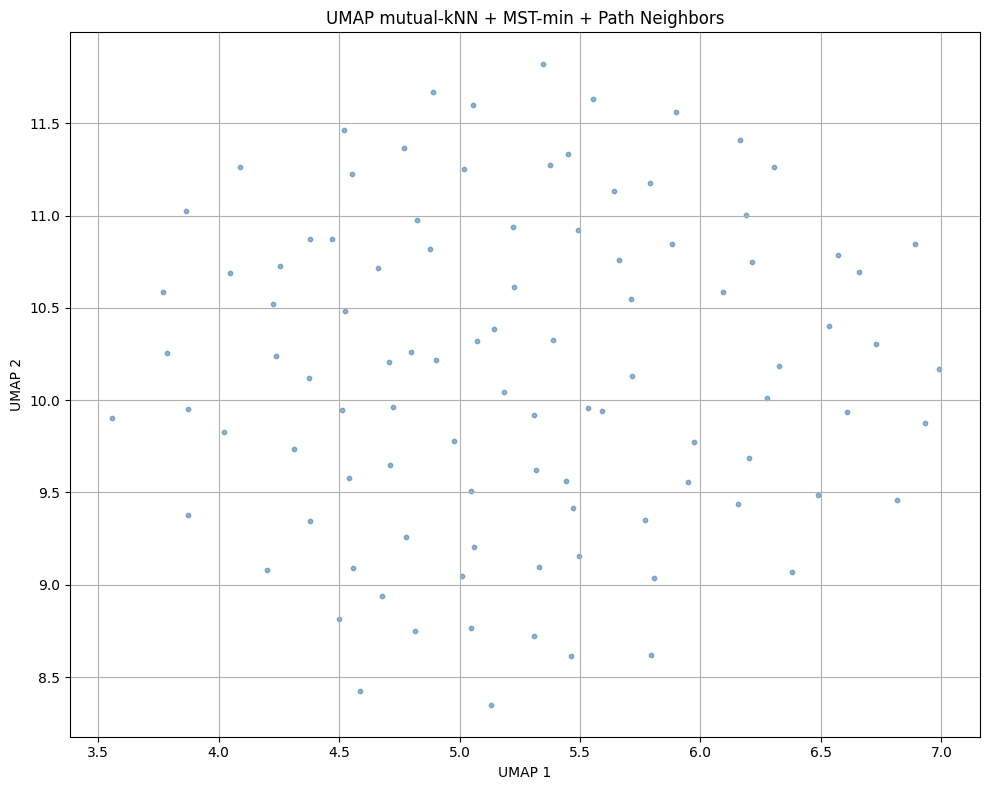

In [ ]:
import matplotlib.pyplot as plt

def plot_umap_no_labels(embedding_2d, title="Projection UMAP 2D sans clustering"):
    """
    Visualisation simple des embeddings UMAP sans étiquette de cluster

    Args:
        embedding_2d (np.ndarray): Embeddings 2D (n_samples x 2)
        title (str): Titre du graphique
    """
    plt.figure(figsize=(10, 8))
    plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=10, c='steelblue', alpha=0.6)
    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_umap_no_labels(embedding_umap, title="UMAP mutual-kNN + MST-min + Path Neighbors")


Début de la réduction UMAP...
Forme des embeddings réduits : (100, 2)
DataFrame pour le plot (premières lignes) :
          x         y   sentences
0  1.711826  2.226767  Sentence 0
1  3.016519  3.129966  Sentence 1
2  0.712268  2.389265  Sentence 2
3  3.815081  5.155043  Sentence 3
4  3.871305  5.131141  Sentence 4
Création du graphique matplotlib...


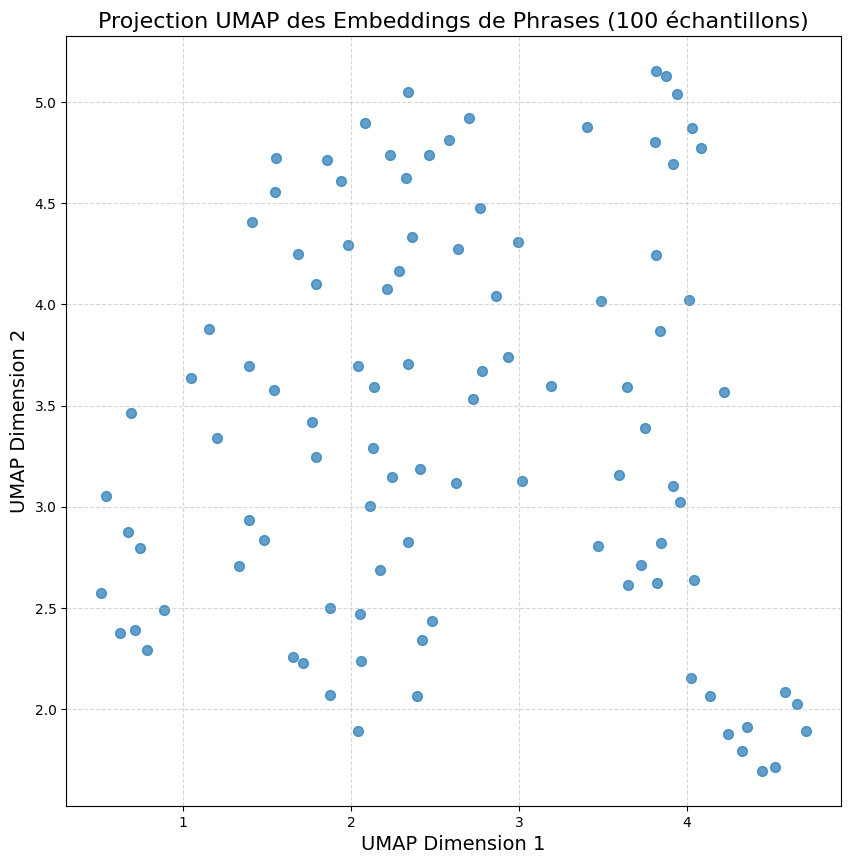

Graphique affiché.


In [ ]:
import umap
import pandas as pd # Assurez-vous que pandas est importé
import matplotlib.pyplot as plt
# import plotly.express as px # Non utilisé dans ce bloc de code matplotlib
# import nbformat # Généralement pas nécessaire pour le plotting UMAP direct

# Supposons que les variables suivantes sont déjà définies :
# sample_embeddings_basic_fr: Un tableau NumPy de vos embeddings (ex: (N, D) où N >= 100)
# df_sample: Un DataFrame pandas correspondant, avec au moins 100 lignes et une colonne 'sentences'

# --- Vérifications initiales (à ajouter pour la robustesse) ---
if 'sample_embeddings_basic_fr' not in locals():
    raise NameError("La variable 'sample_embeddings_basic_fr' n'est pas définie.")
if 'df_sample' not in locals():
    raise NameError("Le DataFrame 'df_sample' n'est pas défini.")
if len(sample_embeddings_basic_fr) < 100:
    raise ValueError("sample_embeddings_basic_fr doit contenir au moins 100 embeddings pour ce code.")
if len(df_sample) < 100:
    raise ValueError("df_sample doit contenir au moins 100 lignes pour ce code.")
# --- Fin des vérifications ---


parameters = {
    "n_neighbors": 15,
    "n_components": 2,    # Nous réduisons à 2 dimensions pour un plot 2D
    "min_dist": 0.1,      # Contrôle la proximité des points dans l'embedding
    "metric": "cosine",   # Métrique de distance appropriée pour les embeddings de texte
    "spread": 0.8,        # Associé à min_dist pour la dispersion
    "random_state": 42,   # Pour la reproductibilité
    "n_epochs": 1000,     # Nombre d'itérations pour l'optimisation
    "learning_rate": 0.01 # Taux d'apprentissage pour l'optimisation
}

print("Début de la réduction UMAP...")
# Sélection des 100 premiers embeddings pour cet exemple
embeddings_to_reduce = sample_embeddings_basic_fr[:100]

# Initialiser et entraîner le modèle UMAP
# Utiliser fit_transform est plus direct si on entraîne et transforme les mêmes données
reducer = umap.UMAP(**parameters)
sample_reduced_embeddings = reducer.fit_transform(embeddings_to_reduce)

# Afficher la forme des embeddings réduits
print(f"Forme des embeddings réduits : {sample_reduced_embeddings.shape}") # Devrait être (100, 2)

# Créer un DataFrame pour les données réduites ou les ajouter au df_sample existant
# Il est plus sûr de travailler sur une copie ou un sous-ensemble pour éviter les problèmes d'indexation
# si df_sample est plus grand que les 100 points traités.

# Option 1: Créer un nouveau DataFrame pour les points réduits (plus propre)
df_reduced_plot = pd.DataFrame({
    'x': sample_reduced_embeddings[:, 0],
    'y': sample_reduced_embeddings[:, 1]
})
# Si vous avez des phrases correspondantes pour ces 100 points :
# Supposons que df_sample['sentences'] contient les phrases.
if 'sentences' in df_sample.columns:
    df_reduced_plot['sentences'] = df_sample['sentences'].iloc[:100].values
else:
    df_reduced_plot['sentences'] = [f"Sentence {i}" for i in range(100)] # Placeholder

# Option 2: Ajouter au df_sample original (assurez-vous que les index correspondent
# ou utilisez .iloc pour les 100 premières lignes si df_sample est plus grand)
# df_sample_plot = df_sample.iloc[:100].copy() # Travailler sur une copie des 100 premières lignes
# df_sample_plot['x'] = sample_reduced_embeddings[:, 0]
# df_sample_plot['y'] = sample_reduced_embeddings[:, 1]
# Pour cette démo, nous utiliserons df_reduced_plot (Option 1)

print(f"DataFrame pour le plot (premières lignes) :\n{df_reduced_plot.head()}")

# Créer la figure matplotlib
print("Création du graphique matplotlib...")
plt.figure(figsize=(10, 10)) # Taille de la figure

# Tracer les points
# Utiliser df_reduced_plot qui contient exactement les 100 points réduits
plt.scatter(
    df_reduced_plot['x'],
    df_reduced_plot['y'],
    alpha=0.7,  # Transparence des points
    s=50        # Taille des points
)

# Ajouter des titres et des labels
plt.title('Projection UMAP des Embeddings de Phrases (100 échantillons)', fontsize=16)
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5) # Ajouter une grille pour une meilleure lisibilité

# Afficher le graphique
plt.show()

print("Graphique affiché.")